In [866]:
import datetime
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('talk')
from statsmodels.tsa import stattools
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 6)

Populating the interactive namespace from numpy and matplotlib


In [867]:

data = pd.read_json('logins.json','r',convert_dates = True)
data = data.set_index('login_time')
data['log_in'] = 1
data.sort_index()
data.head()

,log_in
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [868]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
log_in    93142 non-null int64
dtypes: int64(1)
memory usage: 1.4 MB


In [869]:
#aggregate into 15min intervals
d_15 = data.resample('15min', label = 'left').sum()
d_15.head()

,log_in
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


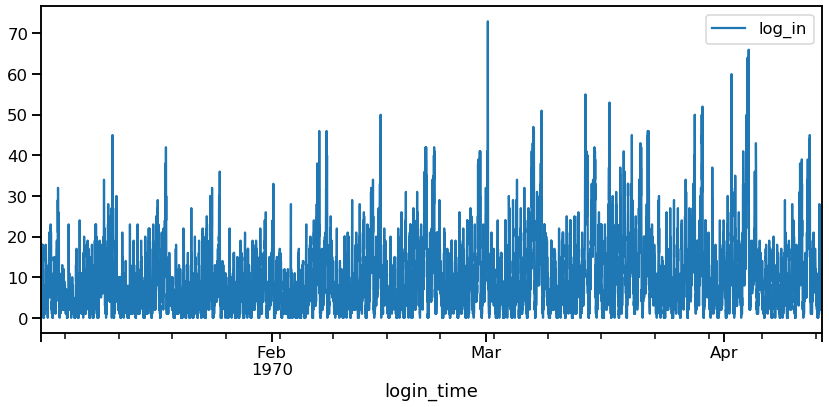

In [870]:
#preview the data
d_15.plot(kind= 'line', figsize = (14,6))
plt.show()

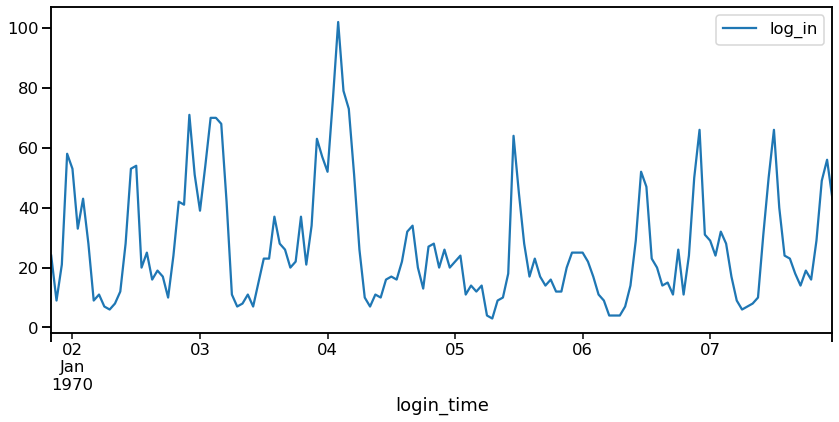

In [871]:
#get an overview of the data, hourly, over the course of one week
d = data.resample('60T', label = 'left').count()
d.loc['1970-01-01':'1970-01-07' ].plot(figsize = (14,6))

In [872]:
# add in the day of the week
d_15['day'] = [datetime.datetime.strftime(x, "%a") for x in d_15.index]
d_15.head()

,log_in,day
login_time,,
1970-01-01 20:00:00,2,Thu
1970-01-01 20:15:00,6,Thu
1970-01-01 20:30:00,9,Thu
1970-01-01 20:45:00,7,Thu
1970-01-01 21:00:00,1,Thu


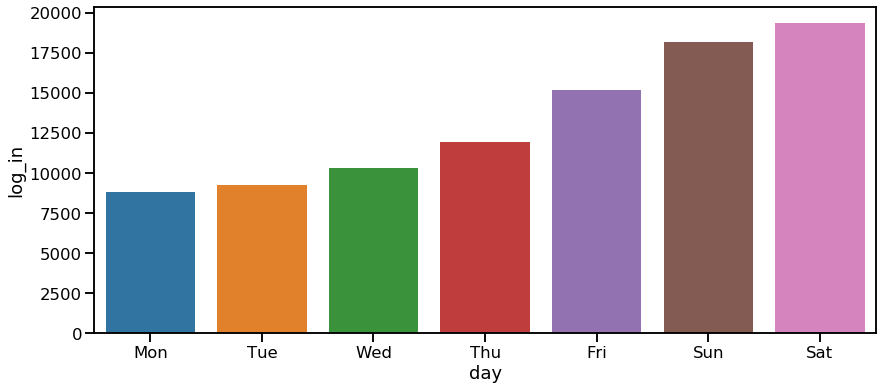

In [873]:
#weekly view of logins per day of the week
weekly = d_15.groupby('day').sum().sort_values(by = 'log_in').reset_index()
_=sns.barplot(x = 'day', y = 'log_in', data = weekly)

In [874]:
def day_of_week(row):
    '''function to add in a weekday or weekend label'''
    if row['day'] in ['Sat', 'Sun']:
        return 'Weekend'
    else:
        return 'Weekday'

In [875]:
# add a column of 'hour'
d_15['hour'] = [datetime.datetime.strftime(x, "%H:%M:%S") for x in d_15.index]
#add in a weekday or weekend label
d_15['day_type'] = d_15.apply(day_of_week, axis = 1)

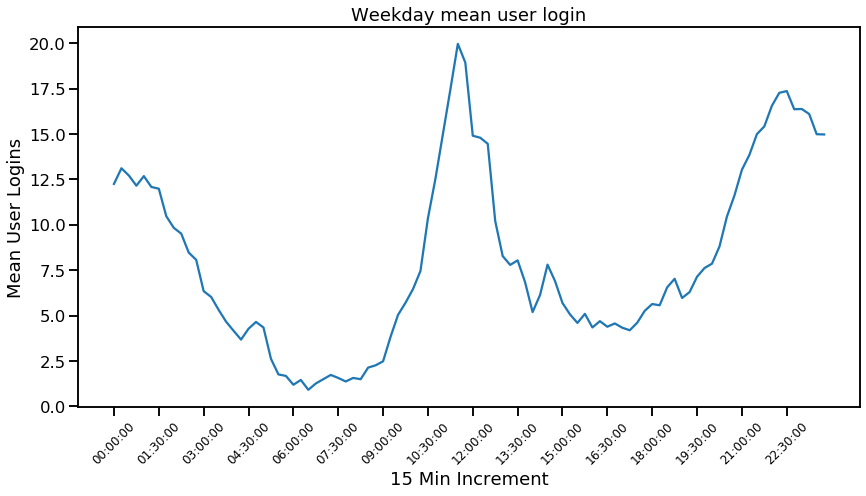

In [876]:
#aggregate data for a mean weekday by 15min interval
weekday = d_15.groupby(['day_type','hour']).mean().loc['Weekday']
fig = plt.figure(figsize = (14, 7))
plt.plot(weekday)
locs, labels = xticks()
plt.xlabel('15 Min Increment')
plt.ylabel('Mean User Logins')
plt.title('Weekday mean user login')
labelss = d_15.groupby(['day_type','hour']).mean().loc['Weekday'].index[0::6]
plt.xticks(locs[::6], labelss, rotation = 45, fontsize = 'large')
plt.show()

For weekdays there appears to be a peak around 11:30am, and second more gradual and longer peak  in the late afternoon. This second peak may be split into two peaks around 10pm with a smaller peak around 1230am. 

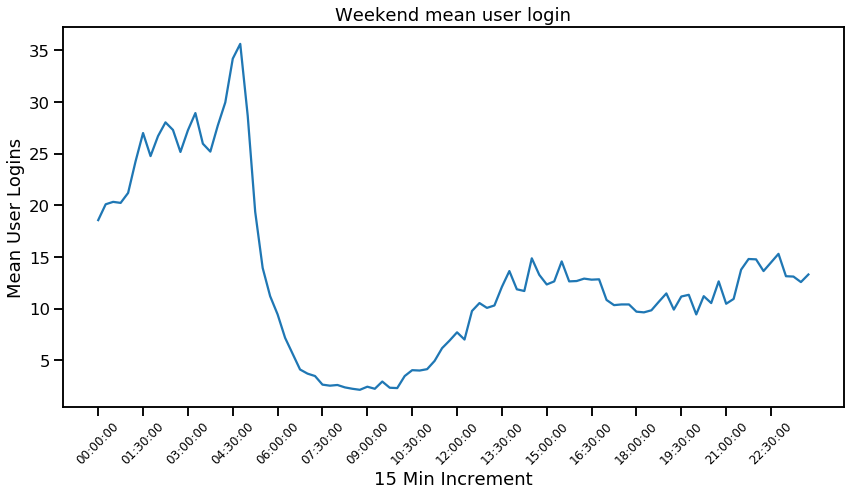

In [877]:
#aggregate data for a mean weekend by 15min interval
weekday = d_15.groupby(['day_type','hour']).mean().loc['Weekend']
fig = plt.figure(figsize = (14, 7))
plt.plot(weekday)
locs, labels = xticks()
plt.xlabel('15 Min Increment')
plt.ylabel('Mean User Logins')
plt.title('Weekend mean user login')
labelss = d_15.groupby(['day_type','hour']).mean().loc['Weekend'].index[0::6]
plt.xticks(locs[::6], labelss, rotation = 45, fontsize = 'large')
plt.show()

For Weekends (Saturday/Sunday) there is a large peak around 430 AM, with a very steep dip at around 545AM. Logins gradually start rising to a peak of 10-15 logins every 15minutes from 1:30PM to 11:00PM.

In [878]:
df = data.reset_index()
df['day'] = df.login_time.apply(lambda x:datetime.datetime.strftime(x, "%a"))
df['time_delta'] = df.login_time.apply(lambda x:pd.to_timedelta(str(datetime.datetime.strftime(x, '%H:%M:%S'))))
df['ns'] = df.login_time.apply(lambda x:pd.Timedelta.to_timedelta64(pd.to_timedelta(str(datetime.datetime.strftime(x, '%H:%M:%S')))))
df['day_type'] = df.apply(day_of_week, axis = 1)
df.head()

,login_time,log_in,day,time_delta,ns,day_type
0,1970-01-01 20:13:18,1,Thu,20:13:18,20:13:18,Weekday
1,1970-01-01 20:16:10,1,Thu,20:16:10,20:16:10,Weekday
2,1970-01-01 20:16:37,1,Thu,20:16:37,20:16:37,Weekday
3,1970-01-01 20:16:36,1,Thu,20:16:36,20:16:36,Weekday
4,1970-01-01 20:26:21,1,Thu,20:26:21,20:26:21,Weekday


In [879]:
#peaks for weekdays and weekends
peaks = {'Weekday 1' : 'wd1', 'Weekday 2' : 'wd2','Weekday 3' : 'wd3','Weekend 1' : 'we',}


#set an arbitrary date to be able to subtract the times of different days
temp_date = pd.Timedelta.to_timedelta64(pd.to_timedelta(str(datetime.datetime.strftime(data.index[0], '%H:%M:%S'))))

df = df.set_index('login_time')

day_rng = pd.date_range(start = df.iloc[0].name.strftime('%Y-%m-%d'), end = df.iloc[-1].name.strftime('%Y-%m-%d'))
day_rng = day_rng.delete([0,(len(day_rng)-1)])


In [923]:



def list_of_means(df, day_rng, peak, weekend = 0):
    '''generates a list of times for a specified peak during the weekday or weekend'''
    top_dates = []
    df_2 = df.copy(deep = True)
    for day in day_rng:
        if day != datetime.datetime.strptime('1970-01-01', '%Y-%m-%d') or day != datetime.datetime.strptime('1970-04-13', '%Y-%m-%d'):
            tmp = df_2.loc[datetime.datetime.strftime(day, '%Y-%m-%d')]
            if peak not in ['wd1','wd2','wd3'] : weekend = 1
            if tmp['day_type'].any() == 'Weekday' and weekend == 0:
                if peak == 'wd2':
                    day_mean = tmp[(tmp.time_delta > pd.to_timedelta('09:00:00')) & (tmp.time_delta<pd.to_timedelta('13:30:00'))].time_delta.values.mean()
                    top_dates.append(day_mean)
                if peak == 'wd3':
                    day_mean = tmp[tmp.time_delta > pd.to_timedelta('19:30:00')].time_delta.values.mean()
                    top_dates.append(day_mean)
                if peak == 'wd1':
                    day_mean = tmp[tmp.time_delta < pd.to_timedelta('04:30:00')].time_delta.values.mean()
                    top_dates.append(day_mean)
            if tmp['day_type'].any() == 'Weekend' and weekend == 1:
                day_mean = tmp[(tmp.time_delta > pd.to_timedelta('00:00:00')) & (tmp.time_delta<pd.to_timedelta('07:30:00'))].time_delta.values.mean()
                top_dates.append(day_mean)
    return top_dates
    
def top_means(row, avg):
    d_avg = pd.to_datetime(pd.Timedelta.to_timedelta64(row['day_avg']))
    ns_avg = pd.to_datetime(avg)
    n_time = (str(ns_avg.year)+'-'+str(ns_avg.month)+'-'+str(ns_avg.day)+' '+str(d_avg.time().hour)+':'+str(d_avg.time().minute)+':'+str(d_avg.time().second))
    d_n_time = datetime.datetime.strptime(n_time, '%Y-%m-%d %H:%M:%S')
    #d_n_time = datetime.datetime.strftime(d_n_time, '%H:%M')
    return(d_n_time)
   #return(((d_avg - ns_avg).seconds//60)%60)

def convert_days(ls_means):
    df = pd.DataFrame({'day_avg':ls_means})
    df['converted_date'] = df.apply(top_means, avg = temp_date, axis = 1)
    return(df['converted_date'])

def bootstrap_replicate_1d(data):
    '''generate bootstrap replicate of 1D data'''
    bs_sample = np.random.choice(data, len(data))
    bs_sample = pd.Series(bs_sample)
    return bs_sample.mean()

def draw_bs_reps(data, size = 1):
    '''draw bootstrap replicates'''
    bs_replicates = list()
    for i in range(size):
        bs_rep = bootstrap_replicate_1d(data)
        bs_replicates.append(bs_rep)
    return np.asarray(bs_replicates)
    
def conf_int(data, size = 1):
    '''generates the confidence interval from the bs_reps'''
    bs_replicates = draw_bs_reps(data, size)
    bs_replicates = np.asarray([pd.Timedelta.to_timedelta64(pd.to_timedelta(str(datetime.datetime.strftime(x, '%H:%M:%S')))) for x in bs_replicates])
    conf_int = np.percentile(bs_replicates, [2.5, 97.5])
    return(datetime.datetime.strftime(pd.to_datetime(conf_int[0]),'%H:%M:%S' ), datetime.datetime.strftime(pd.to_datetime(conf_int[1]),'%H:%M:%S' ))
    


In [924]:
conf_int(convert_days(list_of_means(df, day_rng, 'wd3')), 1000)

C:\Users\Bryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
C:\Users\Bryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
C:\Users\Bryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version


('22:00:45', '22:04:09')

In [925]:


for peak, code in peaks.items():
    ci = conf_int(convert_days(list_of_means(df, day_rng, code)), 1000)
    print('95% confidence interval the {} peak time will be between {} and {}'.format(peak, ci[0], ci[1]))



C:\Users\Bryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
C:\Users\Bryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
C:\Users\Bryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version


95% confidence interval the Weekday 1 peak time will be between 01:45:17 and 01:49:17
95% confidence interval the Weekday 2 peak time will be between 11:33:26 and 11:36:17
95% confidence interval the Weekday 3 peak time will be between 22:00:52 and 22:04:03
95% confidence interval the Weekend 1 peak time will be between 03:11:19 and 03:16:33


C:\Users\Bryan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


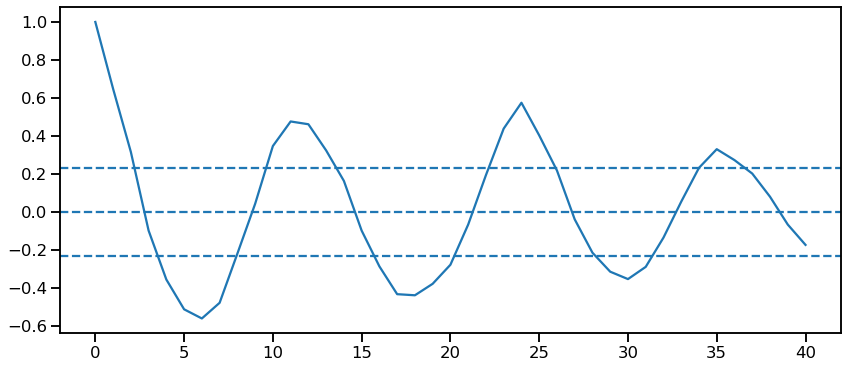

In [926]:
b = d.loc['1970-01-12':'1970-01-14']
acf_result = stattools.acf(b.log_in)
plt.plot(acf_result)
plt.axhline(y=0, linestyle = '--')
plt.axhline(y=-1.96/np.sqrt(len(b.log_in)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(b.log_in)),linestyle='--')

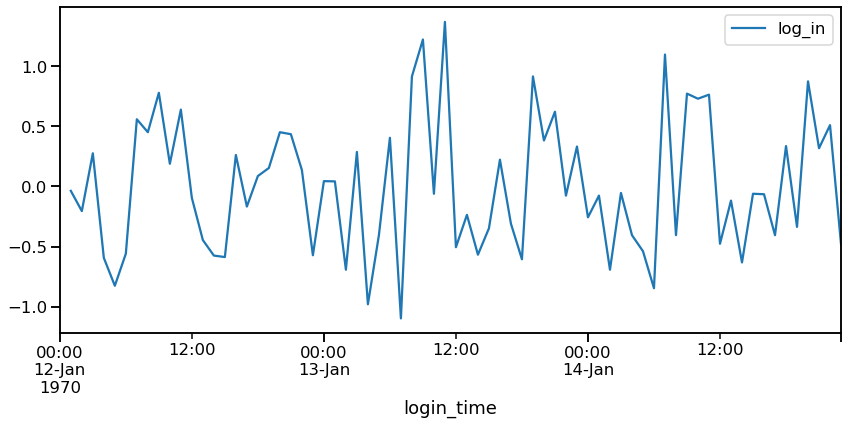

In [928]:
log_d = np.log(b)
log_d_diff = log_d - log_d.shift()
log_d_diff.plot()

In [929]:
log_d_diff.dropna(inplace = True)

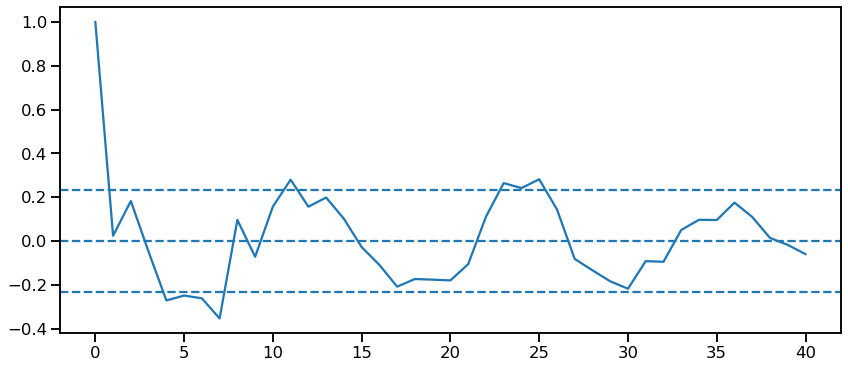

In [930]:
acf_result = stattools.acf(log_d_diff['log_in'])
plt.plot(acf_result)
plt.axhline(y=0, linestyle = '--')
plt.axhline(y=-1.96/np.sqrt(len(log_d_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_d_diff)),linestyle='--')

In [ ]:
b

In [ ]:
data.as_freq('15Min', Method = None)

In [ ]:
data.head()